In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from torch.utils.data.sampler import  SequentialSampler
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
PATH_train="/Users/jimmyfu87/JupyterNotebook/Dataset/dogs-vs-cats-redux-kernels-edition/small/train"
TRAIN =Path(PATH_train)

In [4]:
# how many samples per batch to load
batch_size = 8
# learning rate
LR = 0.0001

In [5]:
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [6]:
train_data = datasets.ImageFolder(TRAIN, transform=transforms)
#print(train_data.class_to_idx)
train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

In [8]:
#自定義model
class CNN_Model(nn.Module):
    #列出需要哪些層
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution 1 , input_shape=(3,224,224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        #output_shape=(16,220,220) #(224-5+1)/2 #(weight-kernel+1)/stride+1 無條件進位
        self.relu1 = nn.ReLU(inplace=True) # activation
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2)
        # Convolution 2 , input_shape=(16,110,110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=11, stride=1, padding=0) 
        #output_shape=(64,50,50) #(110-11+1)/2 
        self.relu2 = nn.ReLU(inplace=True) # activation
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,55,55) #(110/2)
        # Fully connected 1 ,#input_shape=(64*50*50)
        self.fc = nn.Linear(8 * 50 * 50, 2) 
      
    #列出forward的路徑，將init列出的層代入
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out)
        out = self.maxpool2(out)# Max pool 2
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc(out) # Linear function (readout)
        return out

In [9]:
model1=CNN_Model()

In [10]:
# loading the pretrained model
model2 = models.resnet18(pretrained=True)
# Freeze model weights
for param in model2.parameters():
    param.requires_grad = False
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Reset the final fc layer
num_ftrs = model2.fc.in_features
model2.fc = Linear(num_ftrs, 2)
#train fc & layer4[1].conv2
for param in model2.fc.parameters():
    param.requires_grad = True
    
for param in model2.layer4[1].conv2.parameters():
    param.requires_grad = True
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def train(model,n_epochs,train_loader,valid_loader,optimizer,criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        correct,total=0,0
        print('running epoch: {}'.format(epoch))
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in tqdm(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            train_acc=correct/total
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item()*data.size(0))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss =criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            valid_acc=correct/total
            valid_losses.append(loss.item()*data.size(0))

        # calculate average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)

        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)

        # print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

In [13]:
n_epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader,optimizer1,criterion)
#

running epoch: 1


/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Training Loss: 5.431738 	Validation Loss: 5.246575
	Training Accuracy: 0.531915 	Validation Accuracy: 0.524752
running epoch: 2



	Training Loss: 5.352127 	Validation Loss: 5.225400
	Training Accuracy: 0.539007 	Validation Accuracy: 0.534653
running epoch: 3



	Training Loss: 5.249309 	Validation Loss: 5.208762
	Training Accuracy: 0.645390 	Validation Accuracy: 0.603960
running epoch: 4



	Training Loss: 5.109931 	Validation Loss: 5.198850
	Training Accuracy: 0.695035 	Validation Accuracy: 0.643564
running epoch: 5



	Training Loss: 4.883815 	Validation Loss: 5.224941
	Training Accuracy: 0.723404 	Validation Accuracy: 0.653465
running epoch: 6



	Training Loss: 4.630344 	Validation Loss: 5.331329
	Training Accuracy: 0.716312 	Validation Accuracy: 0.638614
running epoch: 7



	Training Loss: 4.392458 	Validation Loss: 5.398491
	Training Accuracy: 0.744681 	Validation Accuracy: 0.658416
running epoch: 8



	Training Loss: 4.163237 	Validation Loss: 5.469649
	Training Accuracy: 0.758865 	Validation Accuracy: 0.693069
running epoch: 9



	Training Loss: 3.879496 	Validation Loss: 5.601272
	Training Accuracy: 0.801418 	Validation Accuracy: 0.722772
running epoch: 10



	Training Loss: 3.645594 	Validation Loss: 5.693671
	Training Accuracy: 0.808511 	Validation Accuracy: 0.727723


In [14]:
n_epochs = 10
optimizer2 = torch.optim.Adam(model2.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his2,valid_acc_his2,train_losses_his2,valid_losses_his2,model2=train(model2,n_epochs,train_loader,valid_loader,optimizer2,criterion)

running epoch: 1


/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Training Loss: 3.628448 	Validation Loss: 1.296028
	Training Accuracy: 0.765957 	Validation Accuracy: 0.816832
running epoch: 2



	Training Loss: 1.379241 	Validation Loss: 0.854029
	Training Accuracy: 0.950355 	Validation Accuracy: 0.945545
running epoch: 3



	Training Loss: 0.912259 	Validation Loss: 0.802782
	Training Accuracy: 0.985816 	Validation Accuracy: 0.970297
running epoch: 4



	Training Loss: 0.669804 	Validation Loss: 0.713576
	Training Accuracy: 0.992908 	Validation Accuracy: 0.980198
running epoch: 5



	Training Loss: 0.521927 	Validation Loss: 0.656807
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099
running epoch: 6



	Training Loss: 0.422528 	Validation Loss: 0.620539
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099
running epoch: 7



	Training Loss: 0.350555 	Validation Loss: 0.588849
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099
running epoch: 8



	Training Loss: 0.296385 	Validation Loss: 0.562058
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099
running epoch: 9



	Training Loss: 0.254444 	Validation Loss: 0.540113
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099
running epoch: 10



	Training Loss: 0.221212 	Validation Loss: 0.522480
	Training Accuracy: 1.000000 	Validation Accuracy: 0.990099


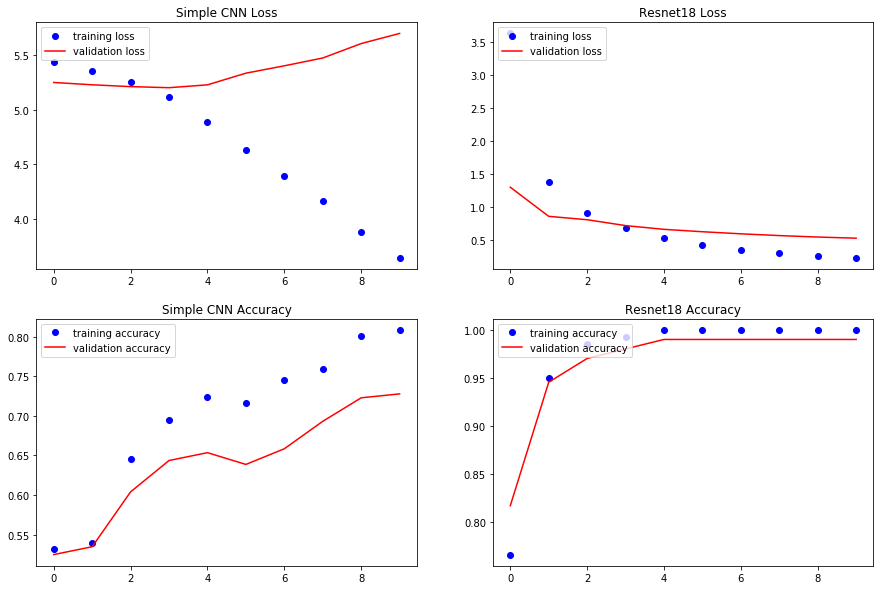

/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNN_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(223)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_losses_his2, 'bo', label = 'training loss')
plt.plot(valid_losses_his2, 'r', label = 'validation loss')
plt.title("Resnet18 Loss")
plt.legend(loc='upper left')
plt.subplot(224)
plt.plot(train_acc_his2, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his2, 'r', label = 'validation accuracy')
plt.title("Resnet18 Accuracy")
plt.legend(loc='upper left')
plt.show()
torch.save(model1, "/Users/jimmyfu87/JupyterNotebook/Save_model/Dogcat_SimpleCNN")
torch.save(model2, "/Users/jimmyfu87/JupyterNotebook/Save_model/Dogcat_resnet18")

In [22]:
# plt.figure(1)
# plt.plot(train_losses_his2, 'bo', label = 'training loss')
# plt.plot(valid_losses_his2, 'r', label = 'validation loss')
# plt.title("Loss")
# plt.legend()
# plt.figure(2)
# plt.plot(train_acc_his2, 'bo', label = 'training accuracy')
# plt.plot(valid_acc_his2, 'r', label = 'validation accuracy')
# plt.title("Accuracy")
# plt.legend()
# plt.show()
# torch.save(model2, "/Users/jimmyfu87/JupyterNotebook/Save_model/Dogcat_resnet18")

In [23]:
model3 = torch.load('/Users/jimmyfu87/JupyterNotebook/Save_model/Dogcat_resnet18_moredata')

In [24]:
# PATH_test="/Users/jimmyfu87/JupyterNotebook/Dataset/dogs-vs-cats-redux-kernels-edition"
# TEST=Path(PATH_test)
# test_data = datasets.ImageFolder(TEST, transform=transforms)
# test_data.class_to_idx
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [25]:
# Dataloader讀取檔案順序未依照1.jpg,2.jpg...的順序，因此無法輸出成csv，但可以用來訓練，因為有batch可用
# result=[]
# def test_submit(model,test_loader):
#     prediction_test = []
#     with torch.no_grad():
#         for data, target in tqdm(test_loader):    
#             if train_on_gpu:
#                 data, target = data.cuda(), target.cuda()
#             # forward pass: compute predicted outputs by passing inputs to the model
#             output = model(data)
#             output=F.softmax(output)
#             #calculate accuracy
#             pred = output.data.max(dim = 1, keepdim = True)[1]
#             #target= int(pred)
#             print(int(pred))
#             prediction_test.append(pred)
#             result.append(pred)
#     return prediction_test
#     #print(prediction_test)

In [26]:
# predict=test_submit(model3,test_loader)

In [27]:
# 將tensor的list數字串起來成numpy.array的格式
# all= torch.tensor([],dtype=torch.long)
# for t in predict:
#     all=torch.cat((all,t),axis=0).type(torch.LongTensor)
# all.size()
# ans=all.numpy()

In [28]:
def test_submit(model,n_img,path): 
    pred_label=[]
    for i in tqdm(range(1,n_img+1)):
        path = image_path + str(i) +'.jpg'
        #讀取照片為PIL圖檔
        img = Image.open(path).convert('RGB')
        #PIL圖檔->transforms(resize(224,224),to_tensor)
        img = transforms(img)
        #原本img是(3,224,224)但Resnet18需要的維度為4維(a,3,224,224)，a為圖片張數
        #一次讀一張，unsqueeze(0)是在0的index增加一個維度，張數為一張因此變成(1,3,224,224)
        img = img.unsqueeze(0)
        #將圖片丟入模型output[貓的數值,狗的數值]
        with torch.no_grad(): 
            output=model3(img)
        #取數值較大的為pred
        pred = output.data.max(dim = 1, keepdim = True)[1]
        pred_label.append(int(pred))
    return pred_label

In [29]:
image_path ='/Users/jimmyfu87/JupyterNotebook/Dataset/dogs-vs-cats-redux-kernels-edition/small/test/'
n_img=10
#n_img=12500
pred_label=test_submit(model3,n_img,image_path)

/Users/jimmyfu87/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
submit = pd.read_csv('/Users/jimmyfu87/JupyterNotebook/Dataset/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submit['label'] = pred_label
submit['label'] = submit['label'].astype(int)
submit.to_csv('/Users/jimmyfu87/JupyterNotebook/Submit_result/submit_dogcat.csv', index= False)

# Kaggle score log loss=1.05551